In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import random

from utils import *
from environment import ButtonsToy
from learner import Learner, bayesian_update, compute_policy, projection
from teacher import BaysesianTeacher, cost

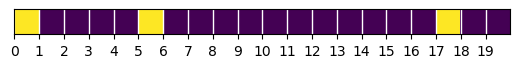

In [2]:
n_buttons = 20
n_music = 3

observation_env = ButtonsToy(n_buttons, n_music)
observation_env.render()

## Learners

In [3]:
types = [0, 1, 2, 3]
traj_size = 150
N = 100
N_envs = 5
dict_learner  = {}
for type in types:
    learner = Learner(type)
    dict_learner[type] = {'actions' : [],
                  'rewards' : []}
    for _ in range(N_envs):
        observation_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            learner.init_env(observation_env)
            actions, rewards = learner.act(traj_size)
            dict_learner[type]['actions'].append(actions)
            dict_learner[type]['rewards'].append(rewards)

/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:32: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:32: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


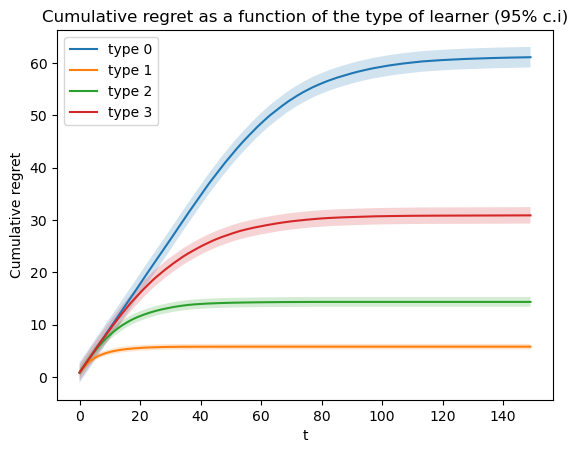

In [5]:
for ii,type in enumerate(types):
    all_rewards = np.array(dict_learner[type]['rewards'])
    all_cum_regrets = np.cumsum(np.ones_like(all_rewards) - all_rewards, axis=1)
    mean, std = np.mean(all_cum_regrets, axis=0), np.std(all_cum_regrets)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(traj_size), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Cumulative regret')
    plt.xlabel('t')
    plt.title('Cumulative regret as a function of the type of learner (95% c.i)')
    plt.legend()

## Bayesian teacher

Observation environment


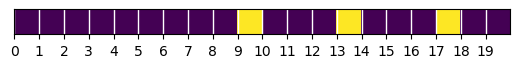

Demonstration environment


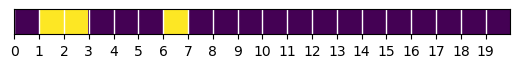

In [3]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=3)
learner.init_env(observation_env)

### Predict learner type (Maximum A Posteriori)

In [7]:
N = 200
N_envs = 10
num_obs = 100

dict = {}

for type in range(num_types):
    dict[type] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env,
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            for _ in range(num_obs):
                accuracies.append(type == teacher.predict_learner_type())
                traj = learner.act()
                teacher.observe(traj)
            dict[type].append(accuracies)

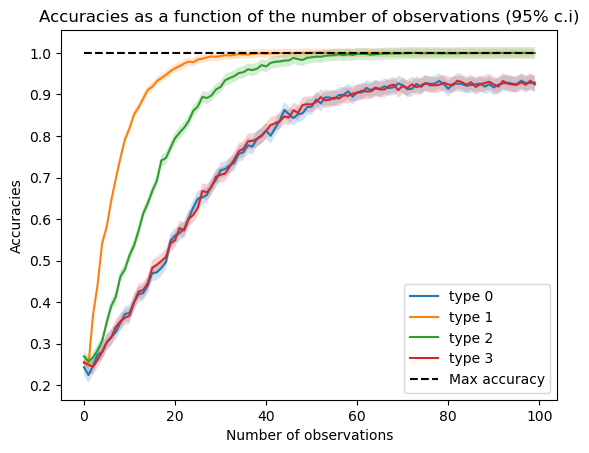

In [9]:
for type in range(num_types):
    accuracies = np.array(dict[type])
    mean, std = np.mean(accuracies, axis=0), np.std(accuracies)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Accuracies')
    plt.xlabel('Number of observations')
    plt.title('Accuracies as a function of the number of observations (95% c.i)')
plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
plt.legend();

In [11]:
## Failure mode studies

N = 100
N_envs = 1
num_obs = 300

LOG = True

dict = {}

for type in range(num_types):
    dict[type] = {}
    dict[type]['accuracies'] = []
    dict[type]['beliefs'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env,
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            all_beliefs = []
            tag_traj = []
            for _ in range(num_obs):
                all_beliefs.append(teacher.beliefs.copy())
                accuracies.append(type == teacher.predict_learner_type())
                traj = learner.act()
                teacher.observe(traj)
                tag_traj.append(traj)

            # If prediction failure after 300 observations
            if LOG and type != teacher.predict_learner_type():
                # print LOG
                print(f'LOG FAILURE : type {type} beliefs {teacher.beliefs} trajectory {tag_traj}')

            dict[type]['beliefs'].append(all_beliefs)
            dict[type]['accuracies'].append(accuracies)

LOG FAILURE : type 0 beliefs [0.5 0.  0.  0.5] trajectory [([18], [0.0]), ([3], [1.0]), ([19], [0.0]), ([8], [0.0]), ([9], [1.0]), ([16], [0.0]), ([17], [0.0]), ([8], [0.0]), ([11], [0.0]), ([19], [0.0]), ([13], [0.0]), ([17], [0.0]), ([8], [0.0]), ([14], [0.0]), ([15], [0.0]), ([13], [0.0]), ([10], [0.0]), ([14], [0.0]), ([1], [0.0]), ([19], [0.0]), ([0], [0.0]), ([14], [0.0]), ([1], [0.0]), ([3], [1.0]), ([8], [0.0]), ([10], [0.0]), ([4], [0.0]), ([3], [1.0]), ([17], [0.0]), ([19], [0.0]), ([10], [0.0]), ([2], [0.0]), ([18], [0.0]), ([3], [1.0]), ([17], [0.0]), ([15], [0.0]), ([13], [0.0]), ([12], [0.0]), ([15], [0.0]), ([15], [0.0]), ([11], [0.0]), ([12], [0.0]), ([7], [0.0]), ([7], [0.0]), ([9], [1.0]), ([6], [0.0]), ([2], [0.0]), ([16], [0.0]), ([2], [0.0]), ([19], [0.0]), ([10], [0.0]), ([11], [0.0]), ([5], [1.0]), ([3], [1.0]), ([3], [1.0]), ([5], [1.0]), ([5], [1.0]), ([5], [1.0]), ([9], [1.0]), ([3], [1.0]), ([5], [1.0]), ([5], [1.0]), ([3], [1.0]), ([3], [1.0]), ([5], [1.0]),

### Demonstrate

Observation environment


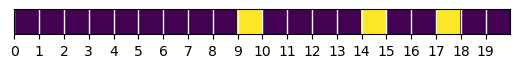

Demonstration environment


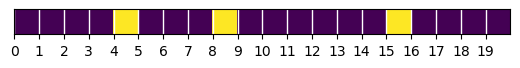

In [4]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
num_demo_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=1)
learner.init_env(observation_env)

In [7]:
# Global evaluation parameters
DICT = {}

N = 100
N_envs = 3
num_obs = 50

n_eval = 20

In [8]:
def evaluate(method, alpha):
    if method not in DICT.keys():
        DICT[method] = {}
    DICT[method][alpha] = {}
    for type in range(num_types):
        DICT[method][alpha][type] = {}
        DICT[method][alpha][type]['rewards'] = []
        DICT[method][alpha][type]['demo'] = []
        DICT[method][alpha][type]['uncertainty'] = []
        DICT[method][alpha][type]['teacher_regret'] = []
        for _ in range(N_envs):
            # Init envs
            observation_env = ButtonsToy(n_buttons, n_music)
            demonstration_env = ButtonsToy(n_buttons, n_music)
            for _ in range(N):
                cum_rewards = []
                all_demo = []
                uncertainties = []
                teacher_regret = []
                for n in range(num_obs):
                    # Init teacher
                    teacher = BaysesianTeacher(env=observation_env,
                                                num_types=num_types)
                    # Init learner
                    learner = Learner(type)
                    learner.init_env(observation_env)
                    # Observe the learner
                    traj = learner.act(size=n)
                    teacher.observe(traj)
                    # Teacher uncertainty
                    uncertainties.append(Shannon_entropy(teacher.beliefs))
                    # Infers the type of learner and chose demonstration
                    teacher.init_env(demonstration_env)
                    demo = teacher.demonstrate(method=method, alpha=alpha)
                    # Teacher regret
                    teacher_regret.append(cost(demo, alpha=alpha) - cost(teacher.demonstrations[type], alpha=alpha))
                    # Show the demonstration
                    learner.init_env(demonstration_env)
                    learner.observe(demo)
                    # Evaluate hwo helpful has been the demonstration
                    _, rewards = learner.act(size=n_eval)
                    # Append
                    cum_rewards.append(np.sum(rewards))
                    all_demo.append(len(demo[0]))
                DICT[method][alpha][type]['rewards'].append(cum_rewards)
                DICT[method][alpha][type]['demo'].append(all_demo)
                DICT[method][alpha][type]['uncertainty'].append(uncertainties)
                DICT[method][alpha][type]['teacher_regret'].append(teacher_regret)

In [ ]:
def display_evaluation(method, alpha):
    demo_colors = ['m', 'red', 'orange', 'pink']

    suptitle = f'Evaluation of the {method} teacher'
    centered_suptitle = suptitle.center(150)
    print(f"\033[1m" + centered_suptitle + f"\033[0m \n cost parameter alpha={alpha}")

    fig = plt.figure(figsize=(15,5))
    # Mean over the type of learner of the total reward on trajectory of size 20  (after seen the demo chosen by the teacher)
    all_evals = np.array([DICT[method][alpha][type]['rewards'] for type in range(num_types)]).mean(axis=0)
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    plt.plot(mean, label=f'Mean over all the types', color='saddlebrown')
    plt.ylim(0, 21)
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='saddlebrown')
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    plt.title(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher ' + f'\n cost parameter alpha={alpha}')

    plt.xlabel('Number of observations')
    plt.ylabel('Learner reward')
    plt.legend()

    fig = plt.figure(figsize=(15,5))
    # Learner total reward on trajectory of size 20 (after seen the demo chosen by the teacher for each type of learner)
    fig.add_subplot(1,2,1)
    for type in range(num_types):
        all_evals = np.array(DICT[method][alpha][type]['rewards'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean, label=f'type = {type}')
        plt.ylim(0, 21)
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    plt.title(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher ' + f'\n cost parameter alpha={alpha}')

    plt.xlabel('Number of observations')
    plt.ylabel('Learner reward')
    plt.legend()

    # Teacher uncertainty
    fig.add_subplot(1,2,2)
    for type in range(num_types):
        all_evals = np.array(DICT[method][alpha][type]['uncertainty'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean, label=f'type = {type}')
        plt.ylim(- 0.5 , Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2)
    plt.plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
    plt.title(fr'$\mathbf{{{method}}}$ teacher')

    plt.xlabel('Number of observations')
    plt.ylabel('Teacher uncertainty (Shannon entropy)')
    plt.legend()


    # Repartition btw type of demonstrations shown
    fig, axes = plt.subplots(1, 4, figsize=(25,5))
    for type in range(num_types):
        ax = axes[type]
        for demo_type in range(num_demo_types):
            demo_rep = np.array(DICT[method][alpha][type]['demo'])
            if demo_type == 0:
                prop_demo = np.array(demo_rep == n_buttons)
            else:
                prop_demo = np.array(demo_rep == demo_type)
            mean = np.mean(prop_demo, axis=0)
            std = np.std(prop_demo)

            ax.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
        ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

        ax.set_title(f'% of each demo type for learner of $\mathbf{{type}}$ ' + fr'$\mathbf{{{type}}}$' +  f'\n {method} teacher, cost parameter alpha={alpha}')
        ax.set_xlabel('Number of observations')
        ax.set_ylabel('Reward')
        ax.legend()

    # Teacher regret on the cost of the demonstration he shows
    fig, axes = plt.subplots(1, 4, figsize=(25,5))
    for type in range(num_types):
        ax = axes[type]
        all_regrets = np.array(DICT[method][alpha][type]['teacher_regret'])
        mean = np.mean(all_regrets, axis=0)
        std = np.std(all_regrets)

        ax.plot(mean, label=f'type = {type}', color='c')
        ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='c')
        ax.set_ylim( - (alpha * (n_buttons - 1) + 0.02), alpha * (n_buttons - 1) + 0.02)
        ax.plot(np.arange(num_obs), [0] * num_obs, c='k', ls='--')

        ax.set_title(f'Teacher regret for learner of $\mathbf{{type}}$ ' + fr'$\mathbf{{{type}}}$' +  f'\n {method} teacher, cost parameter alpha={alpha}')
        ax.set_xlabel('Number of observations')
        ax.set_ylabel('Regret')
        ax.legend()

#### MAP teacher

In [23]:
method = 'MAP'
alpha_values = [0.01, 0.02]

for alpha in alpha_values:
    evaluate(method, alpha)

In [ ]:
method, alpha = 'MAP', alpha_values[0]
display_evaluation(method, alpha)

In [ ]:
method, alpha = 'MAP', alpha_values[1]
display_evaluation(method, alpha)

#### Bayesian teacher

In [ ]:
method = 'Bayesian'
alpha_values = [0.01, 0.02]

for alpha in alpha_values:
    evaluate(method, alpha)

In [ ]:
method, alpha = 'Bayesian', alpha_values[0]
display_evaluation(method, alpha)

In [ ]:
method, alpha = 'Bayesian', alpha_values[1]
display_evaluation(method, alpha)

## ToMNet Teacher

In [1]:
from storage import Storage
from dataset import ToMNetDataset, save_data, load_data
from torch.utils.data import DataLoader

In [4]:
n_buttons = 20
n_music = 3

num_past = 10
max_steps = 30
min_steps = 0

n_agent_train = 10
n_agent_test = 10

batch_size = 10

In [5]:
train_store = Storage(n_buttons=n_buttons,
        n_music=n_music,
        max_steps=max_steps,
        num_past=num_past,
        num_types=4,
        num_agents=n_agent_train,
        num_demo_types=4,
        min_steps=min_steps
        )

eval_store = Storage(n_buttons=n_buttons,
        n_music=n_music,
        max_steps=max_steps,
        num_past=num_past,
        num_types=4,
        num_agents=n_agent_test,
        num_demo_types=4,
        min_steps=min_steps
        )

train_data = train_store.extract()
eval_data = eval_store.extract()
train_dataset = ToMNetDataset(**train_data)
eval_dataset = ToMNetDataset(**eval_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)